Features that I might need
- Last Price
- Open Price
- Close Price
- Day to Day gap
- P/E Ratio
- Market Cap
- Earnings date
- No. Days Post Earnings
- Earnings Actual vs Estimate Difference
- Revenue vs Earnings

In [90]:
import yfinance as yf
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, accuracy_score, confusion_matrix, classification_report
from sklearn.utils.class_weight import compute_sample_weight
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
ticker_symbol = "QQQ"
period = "5y"

ticker = yf.Ticker(ticker_symbol)
original_data = ticker.history(period=period)

In [62]:
price_data = original_data.copy()

In [63]:
new_column = {}
for c in price_data.columns:
    new_column[c] = "_".join(c.split(" ")).lower()
price_data = price_data.rename(columns=new_column)

In [64]:
price_data['previous_close'] = price_data['close'].shift(1)
price_data['day_gap_percent'] = (price_data['open'] - price_data['previous_close']) / price_data['previous_close'] * 100
price_data['day_gap'] = price_data['open'] - price_data['previous_close']
price_data['day_change_percent'] = (price_data['close'] - price_data['previous_close'])/ price_data['previous_close'] * 100
price_data['day_change'] = price_data['close'] - price_data['previous_close']

In [65]:
ma_days = [7, 14, 30, 60, 90, 120, 150, 180, 365]
for days in ma_days:
    # Create a new column name, e.g., 'MA_7', 'MA_14'
    ma_column_name = f"ma_{days}"
    price_above_ma_name = f"close_above_ma_{days}"
    price_ma_diff_percentage_colum_name = f"price_ma_{days}_diff_percent"
    price_ma_diff_colum_name = f"price_ma_{days}_diff"
    price_std_column_name = f"std_{days}"
    bb_upper_column_name = f"bb_upper_{days}"
    bb_lower_column_name = f"bb_lower_{days}"
    bb_percentage_column_name = f"bb_percent_{days}"
    
    # Calculate the moving average on the 'Close' price
    price_data[ma_column_name] = price_data['close'].rolling(window=days).mean()
    price_data[price_above_ma_name] = (price_data[ma_column_name] < price_data['close']).astype(int)
    price_data[price_ma_diff_percentage_colum_name] = (price_data['close'] - price_data[ma_column_name]) / price_data[ma_column_name] * 100
    price_data[price_ma_diff_colum_name] = price_data[ma_column_name] - price_data['close']
    price_data[price_std_column_name] = price_data['close'].rolling(window=days).std()
    price_data[bb_upper_column_name] = price_data[ma_column_name] + (price_data[price_std_column_name] * 2)
    price_data[bb_lower_column_name] = price_data[ma_column_name] - (price_data[price_std_column_name] * 2)

    # Feature: Where is the close relative to the bands? (Normalized)
    price_data[bb_percentage_column_name] = (price_data['close'] - price_data[bb_lower_column_name]) / (price_data[bb_upper_column_name] - price_data[bb_lower_column_name])

In [66]:
delta = price_data['close'].diff(1)
gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()

rs = gain / loss
price_data['rsi_14'] = 100 - (100 / (1 + rs))

In [8]:
# # YFinance limitation can only get income stuff up to 4 quarters back

# def get_daily_features(ticker_symbol="AAPL", period="1y"):
#     """
#     Generates a DataFrame of daily features for a given stock ticker.
#     """
#     print(f"Fetching data for {ticker_symbol}...")

#     # Create ticker object
#     ticker = yf.Ticker(ticker_symbol)

#     # -----------------------------------------------------------------
#     # 1. GET DAILY PRICE DATA
#     # -----------------------------------------------------------------
#     price_data = ticker.history(period=period)

#     # Make index timezone-naive for easier merging
#     price_data.index = price_data.index.tz_localize(None)

#     # Calculate Day-to-Day Gap
#     price_data['Previous_Close'] = price_data['Close'].shift(1)
#     price_data['Day_Gap_Percent'] = (price_data['Open'] - price_data['Previous_Close']) / price_data['Previous_Close'] * 100

#     # Select only the columns we need for the final daily frame
#     daily_df = price_data[['Open', 'Close', 'Day_Gap_Percent']]

#     # -----------------------------------------------------------------
#     # 2. GET QUARTERLY FUNDAMENTALS & EARNINGS DATA
#     # -----------------------------------------------------------------

#     # --- Financials (for Revenue and Net Income) ---
#     q_financials = ticker.quarterly_financials.T # Transpose to have dates as rows
#     q_financials.index = pd.to_datetime(q_financials.index)

#     # Get Revenue and Net Income (Earnings)
#     q_financials['Revenue'] = q_financials.get('Total Revenue')
#     q_financials['Earnings'] = q_financials.get('Net Income')

#     # --- Earnings (for EPS and Surprise) ---
#     q_earnings = ticker.earnings_history
#     q_earnings.index = pd.to_datetime(q_earnings.index)

#     # Calculate Earnings Surprise
#     # q_earnings['Earnings_Surprise_%'] = (q_earnings['epsActual'] - q_earnings['epsEstimate']) / q_earnings['epsEstimate'] * 100
#     # Handle cases where estimate is zero or null
#     # q_earnings['Earnings_Surprise_%'].replace([np.inf, -np.inf], np.nan, inplace=True)

#     # --- Combine Quarterly Data ---
#     # Merge financials and earnings on their quarterly dates
#     quarterly_data = pd.merge(q_financials[['Revenue', 'Earnings']], 
#                                 q_earnings[['epsActual', 'epsEstimate', 'surprisePercent', 'epsDifference']], 
#                                 left_index=True, 
#                                 right_index=True, 
#                                 how='outer')

#     # Calculate TTM (Trailing Twelve Months) EPS
#     # We use 'Actual' EPS for our TTM calculation
#     # quarterly_data['TTM_EPS'] = quarterly_data['epsActual'].rolling(window=4).sum()

#     # -----------------------------------------------------------------
#     # 3. GET STATIC & EVENT DATA
#     # -----------------------------------------------------------------

#     # --- Market Cap (requires current shares outstanding) ---
#     # Note: This uses the *current* share count for all historical data.
#     # A more precise (and much harder) method would use historical shares.
#     try:
#         shares_outstanding = ticker.info['sharesOutstanding']
#     except Exception:
#         print(f"Warning: Could not get 'sharesOutstanding' for {ticker_symbol}.")
#         shares_outstanding = np.nan

#     # --- Earnings Dates ---
#     try:
#         earnings_dates = ticker.earnings_dates.reset_index()
#         # Filter for past earnings dates
#         earnings_dates = earnings_dates[earnings_dates['Reported EPS'].notna()]
#         earnings_dates['Earnings_Date'] = earnings_dates['Earnings Date'].dt.tz_localize(None).dt.date
#         earnings_dates = earnings_dates[['Earnings_Date']].drop_duplicates()
#         earnings_dates.set_index(pd.to_datetime(earnings_dates['Earnings_Date']), inplace=True)
#         # We'll use this for the 'Days_Post_Earnings' calculation
#     except Exception:
#         print(f"Warning: Could not get 'earnings_dates' for {ticker_symbol}.")
#         earnings_dates = pd.DataFrame(columns=['Earnings_Date'])


#     # -----------------------------------------------------------------
#     # 4. MERGE ALL DATA INTO A DAILY FRAME
#     # -----------------------------------------------------------------

#     # Use merge_asof to map quarterly data to all days in that quarter
#     # This finds the last-known quarterly value for any given day.
#     final_df = pd.merge_asof(daily_df.sort_index(),
#                                 quarterly_data.sort_index(),
#                                 left_index=True,
#                                 right_index=True,
#                                 direction='backward') # 'backward' = use last known value

#     # Merge the earnings dates in the same way
#     # We add a copy of the index as a column to calculate the day difference
#     earnings_dates['Last_Earnings_Date'] = earnings_dates.index
#     final_df = pd.merge_asof(final_df.sort_index(),
#                                 earnings_dates[['Last_Earnings_Date']].sort_index(),
#                                 left_index=True,
#                                 right_index=True,
#                                 direction='backward')

#     # -----------------------------------------------------------------
#     # 5. CALCULATE FINAL FEATURES
#     # -----------------------------------------------------------------

#     # Calculate Historical P/E
#     # final_df['P_E_Ratio'] = final_df['Close'] / final_df['TTM_EPS']

#     # Calculate Historical Market Cap
#     final_df['Market_Cap'] = final_df['Close'] * shares_outstanding

#     # Calculate No. Days Post Earnings
#     final_df['Days_Post_Earnings'] = (final_df.index - final_df['Last_Earnings_Date']).dt.days

#     # Rename and select final columns for clarity
#     final_df.rename(columns={
#         'Open': 'Open_Price',
#         'Close': 'Close_Price',
#         'epsActual': 'Quarterly_Actual_EPS',
#         'epsEstimate': 'Quarterly_Estimate_EPS',
#     }, inplace=True)

#     return final_df

# # --- --- --- --- --- ---
# #      RUN THE CODE
# # --- --- --- --- --- ---
# # if __name__ == "__main__":
    
# #     # Get features for Apple
# #     features_aapl = get_daily_features("AAPL")
# #     print("\n--- Daily Features for AAPL (Last 5 Days) ---")
# #     print(features_aapl.tail())
    
# #     # Get features for QQQ
# #     # Note: QQQ will have 'NaN' for many fundamental features
# #     features_qqq = get_daily_features("QQQ")
# #     print("\n--- Daily Features for QQQ (Last 5 Days) ---")
# #     print(features_qqq.tail())

In [9]:
# Assuming 'features_aapl' DataFrame is already created and populated 
# from the previous code block. Make sure that code has run successfully.

if price_data is not None and not price_data.empty:
    print("Generating comparison charts...")
    
    # List of columns to compare against Close_Price
    # Exclude 'Close_Price' itself and any date/index related columns if necessary
    comparison_columns = [col for col in price_data.columns if col != 'close' and 'Date' not in col]
    
    # Loop through each column and create a dual-axis chart
    for feature_col in comparison_columns:
        
        # Check if the column has data to plot (not all NaNs)
        if price_data[feature_col].isnull().all():
            print(f"Skipping '{feature_col}' as it contains only NaN values.")
            continue
            
        print(f"Plotting Close vs. {feature_col}...")
        
        # Create a figure with secondary y-axis
        fig = make_subplots(specs=[[{"secondary_y": True}]])

        # Add Close Price trace (Primary Y-axis)
        fig.add_trace(
            go.Scatter(
                x=price_data.index, 
                y=price_data['close'], 
                name="Close Price",
                line=dict(color='blue')
            ),
            secondary_y=False,
        )

        # Add the other feature trace (Secondary Y-axis)
        # Determine plot type (line or bar) based on feature name or data type
        if 'Percent' in feature_col or 'surprise' in feature_col or 'Gap' in feature_col:
             fig.add_trace(
                go.Bar(
                    x=price_data.index, 
                    y=price_data[feature_col], 
                    name=feature_col,
                    marker=dict(color='orange'),
                    opacity=0.7
                ),
                secondary_y=True,
            )
        else:
             fig.add_trace(
                go.Scatter(
                    x=price_data.index, 
                    y=price_data[feature_col], 
                    name=feature_col,
                    line=dict(color='orange') # Different color for distinction
                ),
                secondary_y=True,
            )


        # Update layout and add titles
        fig.update_layout(
            title_text=f"{ticker_symbol}: Close Price vs. {feature_col}",
            xaxis_title="Date",
            legend_title="Features"
        )

        # Set Y-axis titles
        fig.update_yaxes(title_text="Close Price ($)", secondary_y=False)
        fig.update_yaxes(title_text=feature_col, secondary_y=True)

        fig.show()

else:
    print("DataFrame 'features_aapl' is empty or not defined. Cannot generate plots.")

Generating comparison charts...
Plotting Close vs. open...


Plotting Close vs. high...


Plotting Close vs. low...


Plotting Close vs. volume...


Plotting Close vs. dividends...


Plotting Close vs. stock_splits...


Plotting Close vs. capital_gains...


Plotting Close vs. previous_close...


Plotting Close vs. day_gap_percent...


Plotting Close vs. day_gap...


Plotting Close vs. day_change_percent...


Plotting Close vs. day_change...


Plotting Close vs. ma_7...


Plotting Close vs. close_above_ma_7...


Plotting Close vs. price_ma_7_diff_percent...


Plotting Close vs. price_ma_7_diff...


Plotting Close vs. ma_14...


Plotting Close vs. close_above_ma_14...


Plotting Close vs. price_ma_14_diff_percent...


Plotting Close vs. price_ma_14_diff...


Plotting Close vs. ma_30...


Plotting Close vs. close_above_ma_30...


Plotting Close vs. price_ma_30_diff_percent...


Plotting Close vs. price_ma_30_diff...


Plotting Close vs. ma_60...


Plotting Close vs. close_above_ma_60...


Plotting Close vs. price_ma_60_diff_percent...


Plotting Close vs. price_ma_60_diff...


Plotting Close vs. ma_90...


Plotting Close vs. close_above_ma_90...


Plotting Close vs. price_ma_90_diff_percent...


Plotting Close vs. price_ma_90_diff...


Plotting Close vs. ma_120...


Plotting Close vs. close_above_ma_120...


Plotting Close vs. price_ma_120_diff_percent...


Plotting Close vs. price_ma_120_diff...


Plotting Close vs. ma_150...


Plotting Close vs. close_above_ma_150...


Plotting Close vs. price_ma_150_diff_percent...


Plotting Close vs. price_ma_150_diff...


Plotting Close vs. ma_180...


Plotting Close vs. close_above_ma_180...


Plotting Close vs. price_ma_180_diff_percent...


Plotting Close vs. price_ma_180_diff...


Plotting Close vs. ma_365...


Plotting Close vs. close_above_ma_365...


Plotting Close vs. price_ma_365_diff_percent...


Plotting Close vs. price_ma_365_diff...


Create target

In [92]:
training_data = price_data.copy()
pct_change_tomorrow = price_data['close'].pct_change().shift(-1)
threshold = 0.005 # 0.5% (You can tune this threshold!)

# 2. Create the conditions
conditions = [
    (pct_change_tomorrow > threshold),   # Condition for Buy (1)
    (pct_change_tomorrow < -threshold)   # Condition for Sell (2)
]

# 3. Define the choices for our mapping
# 1 = Buy, 2 = Sell
choices = [1, 2]

# 4. Create the new target column
# np.select(conditions, choices, default=0)
# This means: "If cond 1 is true, give 1. Else if cond 2 is true, give 2. Otherwise, give 0."
training_data['target_multi'] = np.select(conditions, choices, default=0)
# training_data['target'] = (training_data['close'].shift(-1) > training_data['close']).astype(int)
training_data.dropna(inplace=True)

In [93]:
y = training_data['target_multi']
x = training_data.drop(columns=[
    'target_multi',             
    'day_change_percent', 
    'day_change'          
])

In [94]:
x_train_full, x_test, y_train_full, y_test = train_test_split(x, y, test_size=0.2, shuffle=False)
x_train, x_val, y_train, y_val = train_test_split(x_train_full, y_train_full, test_size=0.2, shuffle=False)

In [95]:
sample_weights = compute_sample_weight(
    class_weight='balanced',
    y=y_train
)

In [96]:
model = xgb.XGBClassifier(
    # --- CRITICAL CHANGES ---
    objective='multi:softmax',  # Use 'multi:softmax' for multiclass
    num_class=3,                # Tell it there are 3 classes (0, 1, 2)
    
    # --- Other parameters (can be tuned) ---
    n_estimators=1000,
    learning_rate=0.01,
    max_depth=5,
    early_stopping_rounds=50,
    
    # We no longer use scale_pos_weight
)

In [97]:
model.fit(
    x_train, 
    y_train,
    eval_set=[(x_val, y_val)],
    sample_weight=sample_weights, # <-- Pass the weights here
    verbose=False
)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=50,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.01, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=1000,
              n_jobs=None, num_class=3, ...)

In [99]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

predictions = model.predict(x_test)

# 1. Check accuracy
accuracy = accuracy_score(y_test, predictions)
print(f"Test Accuracy: {accuracy * 100:.2f}%")

# 2. Check the 3x3 Confusion Matrix
print("\n--- Confusion Matrix ---")
print(confusion_matrix(y_test, predictions))

# 3. Check the detailed report
print("\n--- Classification Report ---")
target_names = ['Do Nothing (0)', 'Buy (1)', 'Sell (2)']
print(classification_report(y_test, predictions, target_names=target_names))

Test Accuracy: 43.02%

--- Confusion Matrix ---
[[42 14 21]
 [18 21 23]
 [18  8 14]]

--- Classification Report ---
                precision    recall  f1-score   support

Do Nothing (0)       0.54      0.55      0.54        77
       Buy (1)       0.49      0.34      0.40        62
      Sell (2)       0.24      0.35      0.29        40

      accuracy                           0.43       179
     macro avg       0.42      0.41      0.41       179
  weighted avg       0.45      0.43      0.44       179



In [98]:
predictions = model.predict(x_test)

# Calculate the RMSE
rmse = np.sqrt(mean_squared_error(y_test, predictions))
print(f"Test RMSE: {rmse:.4f}")

# For context, compare this to the standard deviation of the target
print(f"Test Target Standard Deviation: {y_test.std():.4f}")
print("\n--- Results with new threshold ---")
print(f"Total 'Up' (1) predictions:   {np.sum(predictions == 1)}")
print(f"Total 'Down' (0) predictions: {np.sum(predictions == 0)}")
# 3. Evaluate with accuracy
predictions = model.predict(x_test)
accuracy = accuracy_score(y_test, predictions)
print(f"Test Accuracy: {accuracy * 100:.2f}%")

Test RMSE: 1.1061
Test Target Standard Deviation: 0.7838

--- Results with new threshold ---
Total 'Up' (1) predictions:   43
Total 'Down' (0) predictions: 78
Test Accuracy: 43.02%


In [79]:
y_test[y_test == 1].sum()

np.int64(105)

In [75]:
# 'y_test' is your true labels
# 'new_predictions' is what your model predicted (from the threshold)
cm = confusion_matrix(y_test, predictions)

print("--- Confusion Matrix ---")
print(cm)
print("------------------------")

# You can also use this to see Precision, Recall, and F1-score
from sklearn.metrics import classification_report
print("\n--- Classification Report ---")
print(classification_report(y_test, predictions, target_names=['Down (0)', 'Up (1)']))

--- Confusion Matrix ---
[[  0  74]
 [  0 105]]
------------------------

--- Classification Report ---
              precision    recall  f1-score   support

    Down (0)       0.00      0.00      0.00        74
      Up (1)       0.59      1.00      0.74       105

    accuracy                           0.59       179
   macro avg       0.29      0.50      0.37       179
weighted avg       0.34      0.59      0.43       179



c:\Projects\stock_statistical_analysis\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

c:\Projects\stock_statistical_analysis\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

c:\Projects\stock_statistical_analysis\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.




--- Top 10 Most Important Features ---
                      feature  importance
32           price_ma_90_diff    0.049334
44          price_ma_180_diff    0.041783
27   price_ma_60_diff_percent    0.037088
38         close_above_ma_150    0.036826
10                    day_gap    0.036291
3                       close    0.034951
2                         low    0.033006
45                     ma_365    0.032751
37                     ma_150    0.032456
47  price_ma_365_diff_percent    0.032205


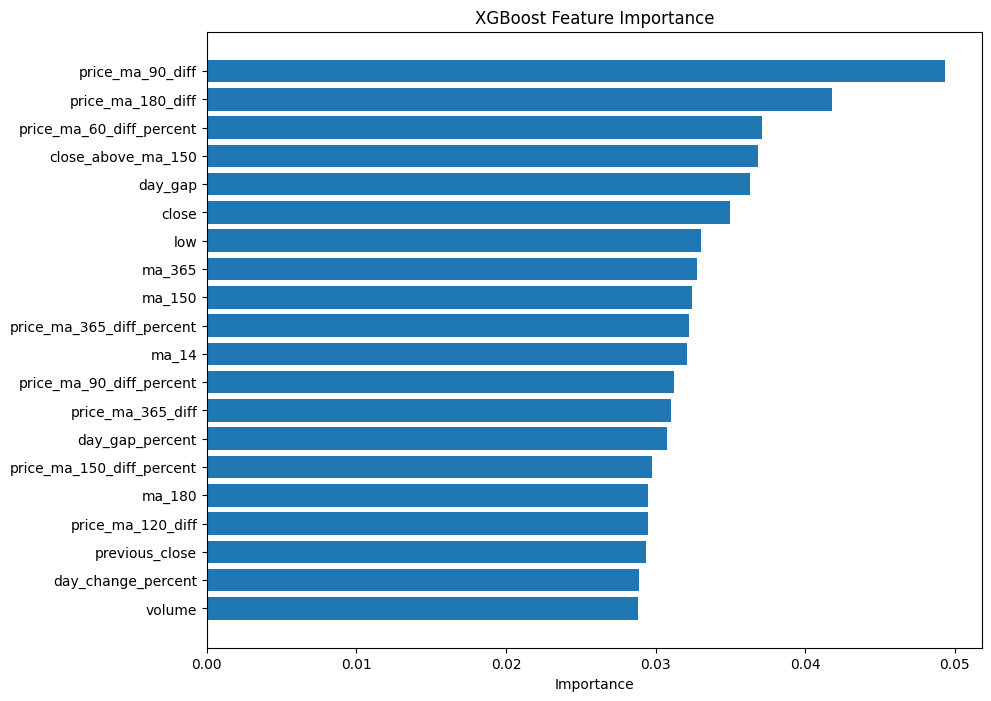

In [19]:
# Create a DataFrame of feature importances
importances = model.feature_importances_
feature_names = x.columns

feature_importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': importances
}).sort_values(by='importance', ascending=False)

print("\n--- Top 10 Most Important Features ---")
print(feature_importance_df.head(10))

# Plot the top 20 features
plt.figure(figsize=(10, 8))
plt.title("XGBoost Feature Importance")
plt.barh(
    feature_importance_df['feature'].head(20), 
    feature_importance_df['importance'].head(20)
)
plt.xlabel("Importance")
plt.gca().invert_yaxis() # Display most important at the top
plt.show()

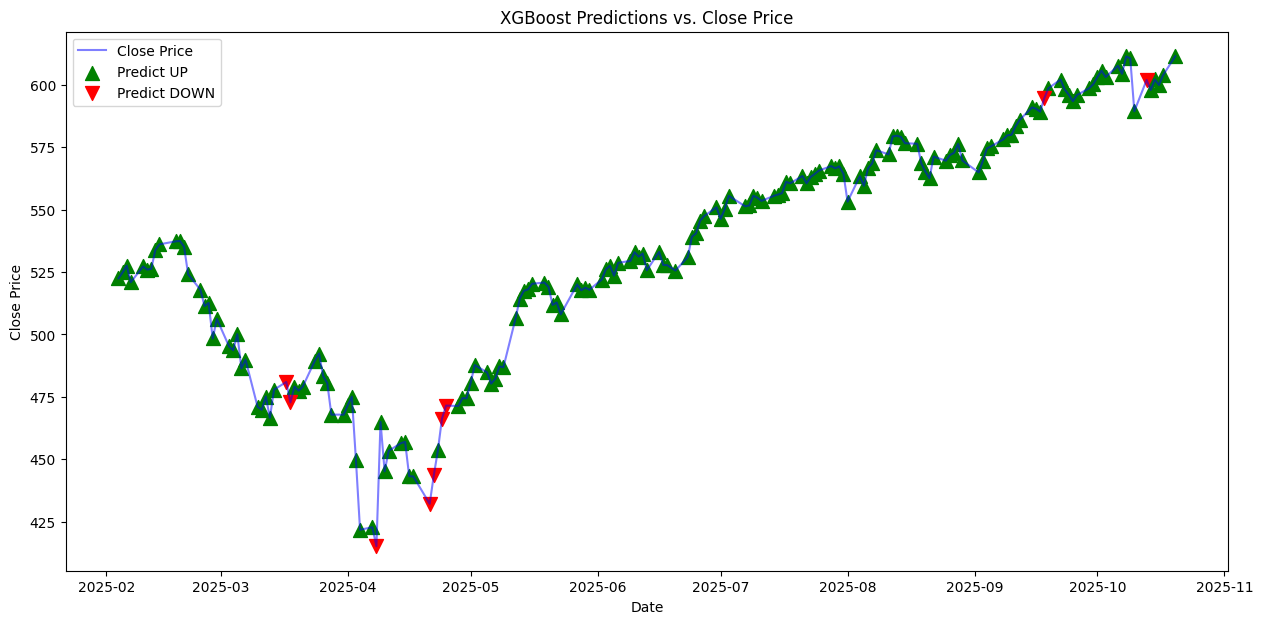

In [42]:
import matplotlib.pyplot as plt
import pandas as pd

# 1. Combine your test features and predictions into one DataFrame
# We use x_test because it has the correct dates (index) and the close price
plot_df = x_test.copy()
plot_df['prediction'] = predictions

# 2. Create two new columns for "up" and "down" signals
# We only want to plot a marker when a signal occurs.
# We get the 'close' price at that index if the condition is met, otherwise NaN.
up_signals = plot_df[plot_df['prediction'] == 1]['close']
down_signals = plot_df[plot_df['prediction'] == 0]['close']

# 3. Create the plot
plt.figure(figsize=(15, 7))

# Plot the close price line
plt.plot(plot_df.index, plot_df['close'], label='Close Price', color='blue', alpha=0.5)

# Plot the 'Up' (1) predictions as green triangles
plt.scatter(up_signals.index, up_signals,
            label='Predict UP', marker='^', color='green', s=100) # s=100 is marker size

# Plot the 'Down' (0) predictions as red triangles
plt.scatter(down_signals.index, down_signals,
            label='Predict DOWN', marker='v', color='red', s=100)

plt.title('XGBoost Predictions vs. Close Price')
plt.ylabel('Close Price')
plt.xlabel('Date')
plt.legend()
plt.show()